<a href="https://colab.research.google.com/github/jaya01092005/HIV-Drug-Resistance-Prediction/blob/main/NNRTI_resistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io

In [ ]:
class HIVDrugResistanceDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(
            sequences,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt",
            add_special_tokens=True
        )
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
def process_resistance_data(df):
    """
    Enhanced data processing with handling for rare classes
    """
    sequences = []
    for _, row in df.iterrows():
        # Extract mutation list from the last column
        mutation_pattern = row['CompMutList']

        if pd.isna(mutation_pattern) or mutation_pattern == '-':
            sequences.append("WILDTYPE NO_MUTATIONS SUSCEPTIBLE")
        else:
            mutations = mutation_pattern.split(", ")
            mutations = [f"RT_{mut}" for mut in mutations]
            mutations_with_context = []
            for mut in mutations:
                position = ''.join(filter(str.isdigit, mut))
                mutations_with_context.append(f"{mut} POS_{position}")
            sequences.append(" ".join(mutations_with_context))

    # Define drugs based on the columns in the dataset
    drugs = ['EFV','NVP','ETR']
    labels = []
    valid_samples_mask = []  # Track which samples to keep

    # First pass to count classes for each drug
    drug_class_counts = {drug: {0: 0, 1: 0} for drug in drugs}
    for _, row in df.iterrows():
        for drug in drugs:
            if pd.isna(row[drug]) or row[drug] == 'NA':
                drug_class_counts[drug][0] += 1
            else:
                fold_value = float(row[drug])
                label = 1 if fold_value > 3.5 else 0
                drug_class_counts[drug][label] += 1

    # Print class distribution before filtering
    print("Class distribution before filtering:")
    for drug in drugs:
        print(f"\n{drug}:")
        print(f"Class 0 (non-resistant): {drug_class_counts[drug][0]}")
        print(f"Class 1 (resistant): {drug_class_counts[drug][1]}")

    # Second pass to create labels, excluding samples with rare classes
    for _, row in df.iterrows():
        drug_labels = []
        valid_sample = True

        for drug in drugs:
            if pd.isna(row[drug]) or row[drug] == 'NA':
                label = 0
            else:
                fold_value = float(row[drug])
                label = 1 if fold_value > 3.5 else 0

            # Check if this class is rare for this drug
            if drug_class_counts[drug][label] < 2:
                valid_sample = False
                break

            drug_labels.append(label)

        if valid_sample:
            labels.append(drug_labels)
            valid_samples_mask.append(True)
        else:
            valid_samples_mask.append(False)

    # Filter sequences to match valid labels
    sequences = [seq for seq, mask in zip(sequences, valid_samples_mask) if mask]

    # Print final class distribution
    print("\nClass distribution after filtering rare classes:")
    filtered_df = df[valid_samples_mask]
    for drug in drugs:
        resistant_count = sum(1 for _, row in filtered_df.iterrows()
                            if not pd.isna(row[drug]) and row[drug] != 'NA' and float(row[drug]) > 10)
        non_resistant_count = len(filtered_df) - resistant_count
        print(f"\n{drug}:")
        print(f"Class 0 (non-resistant): {non_resistant_count}")
        print(f"Class 1 (resistant): {resistant_count}")

    return sequences, labels

In [ ]:
def upload_and_process_file():
    """
    Handle file upload in Google Colab and process the data
    """
    print("Please upload your resistance data file...")
    uploaded = files.upload()

    file_name = list(uploaded.keys())[0]
    content = uploaded[file_name]

    if file_name.endswith('.txt'):
        df = pd.read_csv(io.BytesIO(content), sep='\t')
    else:
        raise ValueError("Please upload a tab-separated txt file")

    return df

In [ ]:
def calculate_metrics(predictions, true_labels):
    """
    Calculate various metrics for model evaluation
    """
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Calculate basic metrics
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels.flatten(), predictions.flatten(), average="binary")
    accuracy = accuracy_score(true_labels.flatten(), predictions.flatten())

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels.flatten(), predictions.flatten())
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    metrics = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "specificity": specificity,
        "npv": npv,
        "confusion_matrix": {
            "true_positives": int(tp),
            "true_negatives": int(tn),
            "false_positives": int(fp),
            "false_negatives": int(fn)
        }
    }

    return metrics, conf_matrix

In [ ]:
def plot_confusion_matrix(conf_matrix):
    """
    Plot a confusion matrix as a heatmap
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Predicted Negative", "Predicted Positive"],
        yticklabels=["Actual Negative", "Actual Positive"]
    )
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def print_metrics(metrics):
    """
    Print formatted metrics and confusion matrix elements
    """
    print("\nValidation Metrics:")
    print("-" * 40)

    for metric, value in metrics.items():
        if metric != "confusion_matrix":
            print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

    print("\nConfusion Matrix Elements:")
    for key, value in metrics["confusion_matrix"].items():
        print(f"{key.replace('_', ' ').title()}: {value}")
    print("-" * 40)

In [ ]:
def get_warmup_steps(config, num_training_steps):
    """Calculate warmup steps based on either direct steps or ratio"""
    if 'warmup_steps' in config:
        return config['warmup_steps']
    elif 'warmup_ratio' in config:
        return int(num_training_steps * config['warmup_ratio'])
    else:
        # Default to 10% if neither is specified
        return int(num_training_steps * 0.1)

In [ ]:
def train_model(train_dataset, val_dataset, model, device, config):
    """
    Enhanced training function with better optimization and monitoring
    """
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

    # Initialize optimizer with weight decay
    optimizer = AdamW(model.parameters(),
                     lr=config['learning_rate'],
                     weight_decay=config['weight_decay'])

    # Calculate total training steps and warmup steps
    num_training_steps = len(train_loader) * config['num_epochs']
    warmup_steps = get_warmup_steps(config, num_training_steps)

    print(f"Total training steps: {num_training_steps}")
    print(f"Warmup steps: {warmup_steps}")

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=num_training_steps
    )

    best_val_loss = float("inf")
    patience = config['patience']
    patience_counter = 0
    training_stats = []

    for epoch in range(config['num_epochs']):
        model.train()
        total_loss = 0
        steps = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Add L1 regularization if specified
            if 'l1_lambda' in config:
                l1_lambda = config['l1_lambda']
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm

            total_loss += loss.item()
            steps += 1

            loss.backward()

            # Gradient clipping
            if 'max_grad_norm' in config:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])

            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / steps

        # Validation phase
        model.eval()
        val_loss = 0
        y_true_all, y_scores_all = [], []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()

                logits = outputs.logits
                probabilities = torch.sigmoid(logits).cpu().numpy()
                y_scores_all.extend(probabilities)
                y_true_all.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)

        # Generate PR Curves for Each Drug
        y_true_all = np.array(y_true_all)
        y_scores_all = np.array(y_scores_all)
        num_drugs = y_true_all.shape[1]


        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

        for i in range(num_drugs):
            precision, recall, _ = precision_recall_curve(y_true_all[:, i], y_scores_all[:, i])
            pr_auc = auc(recall, precision)
            plt.figure()
            plt.plot(recall, precision, label="Drug", color=colors[i % len(colors)])
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title(f"Precision-Recall Curve for Drug {i + 1}")
            plt.legend()
            plt.grid(False)
            plt.show()

            print(f"PR-AUC for Drug {i + 1}: {pr_auc:.4f}")

        # Calculate and print metrics
        predictions = (np.array(y_scores_all) > 0.5).astype(int)
        metrics, conf_matrix = calculate_metrics(predictions, y_true_all)
        current_lr = scheduler.get_last_lr()[0]

        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Learning Rate: {current_lr:.2e}")
        print_metrics(metrics)
        plot_confusion_matrix(conf_matrix)

        # Save training stats
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'learning_rate': current_lr,
            **metrics
        })

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            model.save_pretrained("best_hiv_resistance_model")
            print("Saved best model!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

    return model, training_stats

Using device: cuda
Loading model and tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Please upload your resistance data file...


Saving NNRTI_DataSet.txt to NNRTI_DataSet.txt
Class distribution before filtering:

EFV:
Class 0 (non-resistant): 1306
Class 1 (resistant): 983

NVP:
Class 0 (non-resistant): 1128
Class 1 (resistant): 1161

ETR:
Class 0 (non-resistant): 2063
Class 1 (resistant): 226

Class distribution after filtering rare classes:

EFV:
Class 0 (non-resistant): 1523
Class 1 (resistant): 766

NVP:
Class 0 (non-resistant): 1212
Class 1 (resistant): 1077

ETR:
Class 0 (non-resistant): 2177
Class 1 (resistant): 112


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total training steps: 4580
Warmup steps: 687


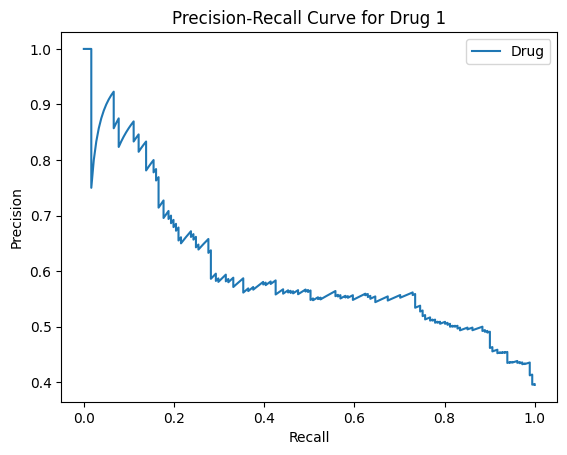

PR-AUC for Drug 1: 0.6026


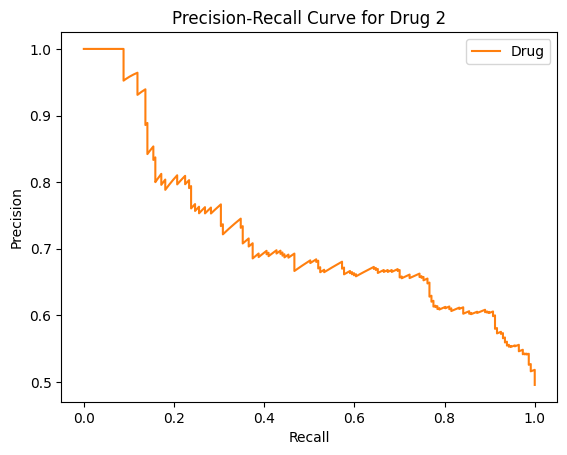

PR-AUC for Drug 2: 0.7188


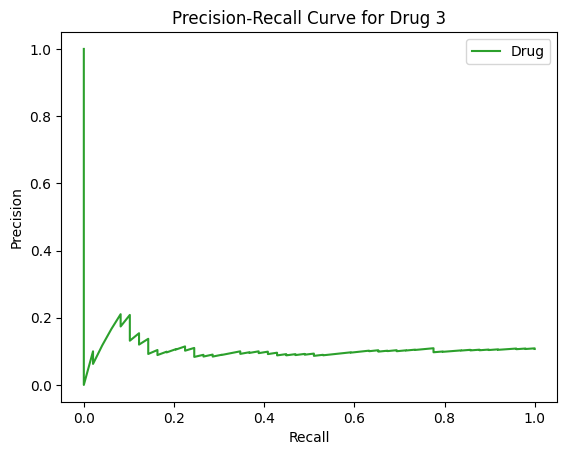

PR-AUC for Drug 3: 0.1034

Epoch 1/20
Training Loss: 0.5932
Validation Loss: 0.5320
Learning Rate: 3.33e-06

Validation Metrics:
----------------------------------------
Precision: 0.6386
Recall: 0.4486
F1 Score: 0.5270
Accuracy: 0.7322
Specificity: 0.8735
Npv: 0.7607

Confusion Matrix Elements:
True Positives: 205
True Negatives: 801
False Positives: 116
False Negatives: 252
----------------------------------------


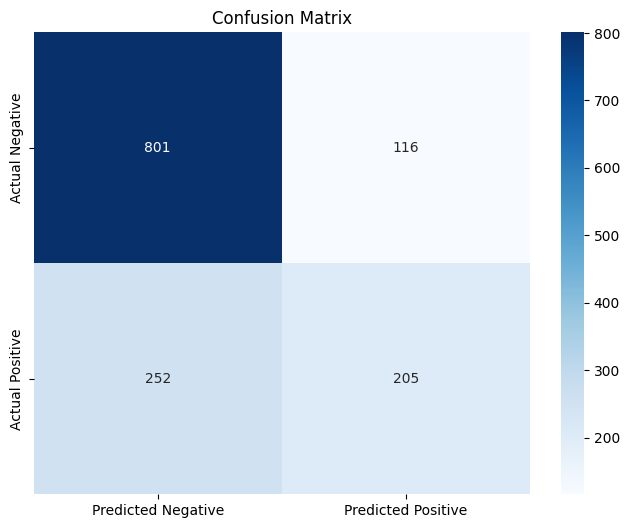

Saved best model!


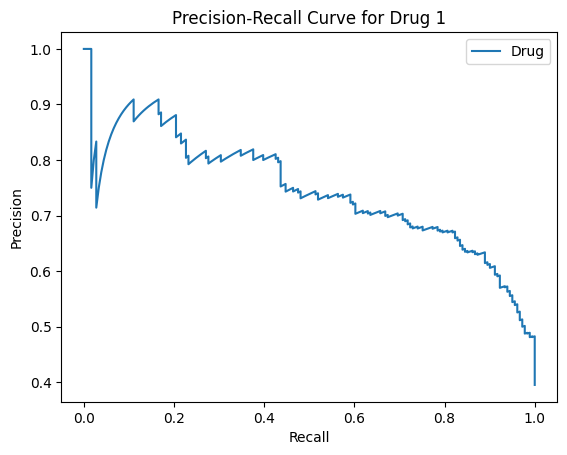

PR-AUC for Drug 1: 0.7445


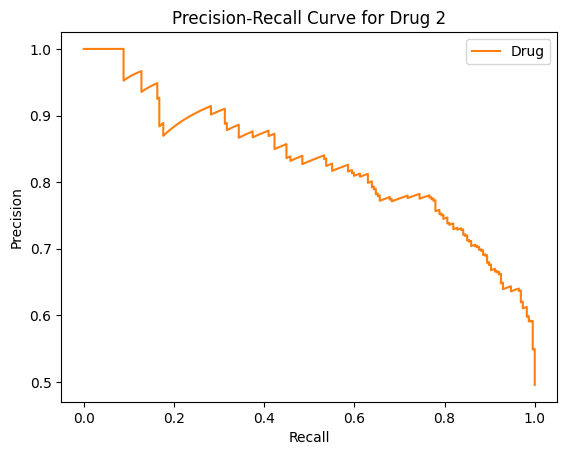

PR-AUC for Drug 2: 0.8289


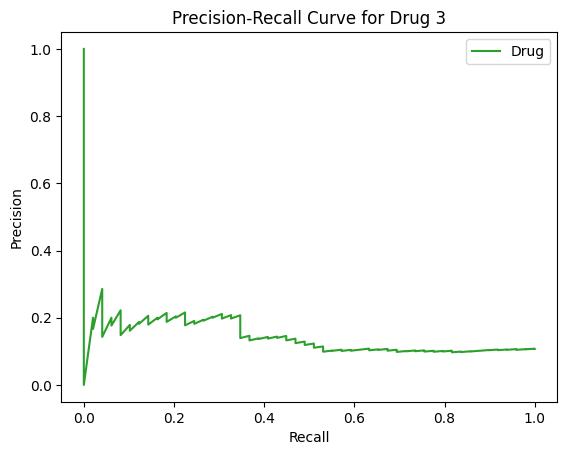

PR-AUC for Drug 3: 0.1380

Epoch 2/20
Training Loss: 0.5293
Validation Loss: 0.4572
Learning Rate: 6.67e-06

Validation Metrics:
----------------------------------------
Precision: 0.7246
Recall: 0.7024
F1 Score: 0.7133
Accuracy: 0.8122
Specificity: 0.8670
Npv: 0.8539

Confusion Matrix Elements:
True Positives: 321
True Negatives: 795
False Positives: 122
False Negatives: 136
----------------------------------------


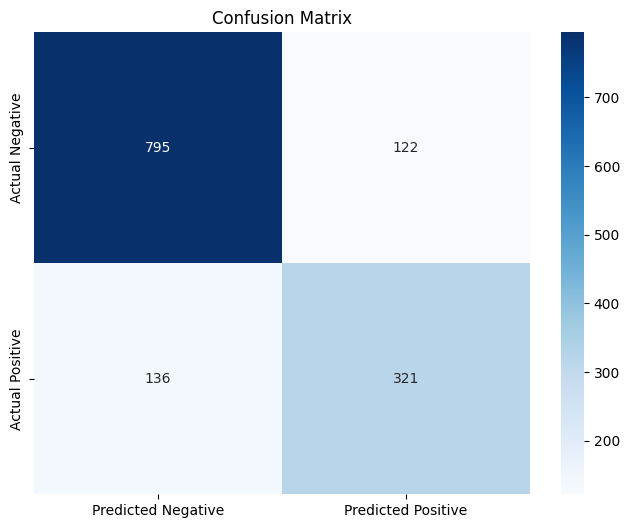

Saved best model!


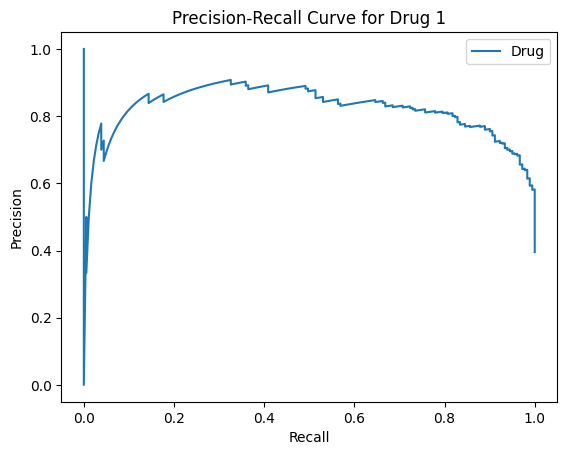

PR-AUC for Drug 1: 0.8159


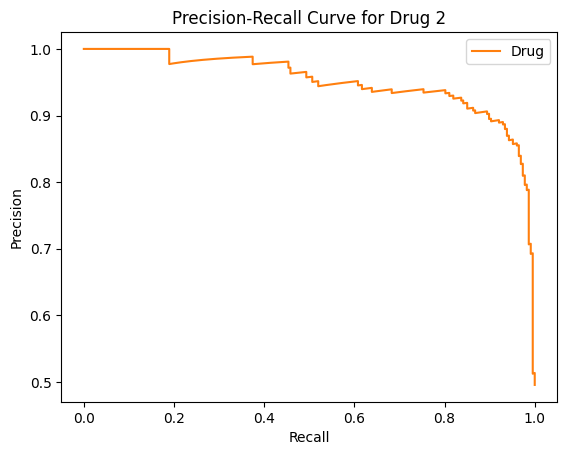

PR-AUC for Drug 2: 0.9511


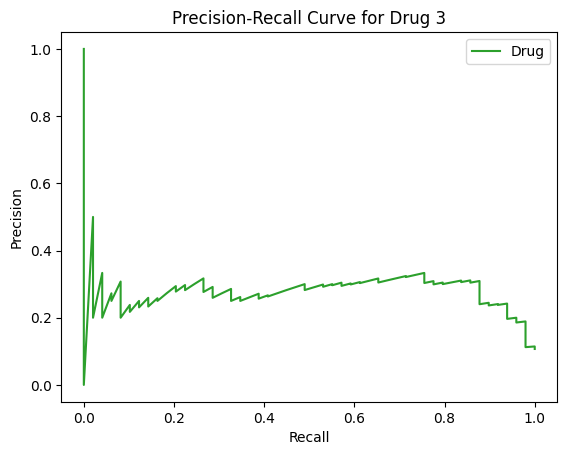

PR-AUC for Drug 3: 0.2746

Epoch 3/20
Training Loss: 0.4155
Validation Loss: 0.3735
Learning Rate: 1.00e-05

Validation Metrics:
----------------------------------------
Precision: 0.7727
Recall: 0.8556
F1 Score: 0.8120
Accuracy: 0.8683
Specificity: 0.8746
Npv: 0.9240

Confusion Matrix Elements:
True Positives: 391
True Negatives: 802
False Positives: 115
False Negatives: 66
----------------------------------------


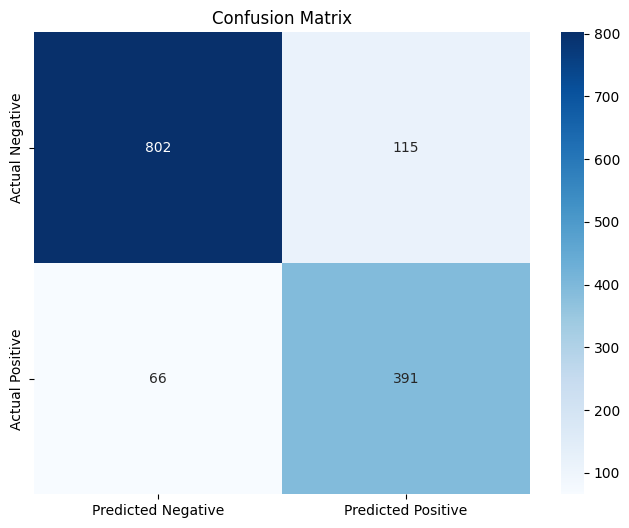

Saved best model!


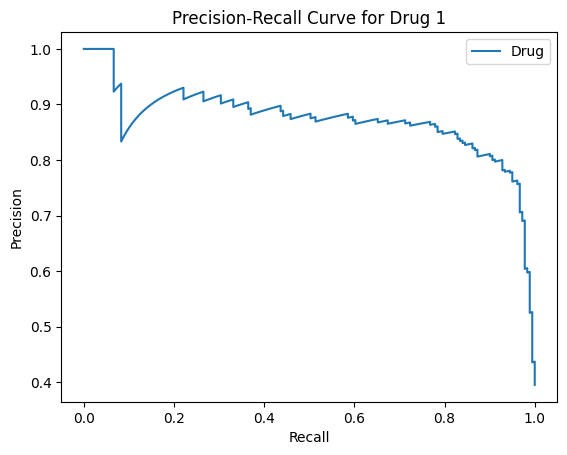

PR-AUC for Drug 1: 0.8718


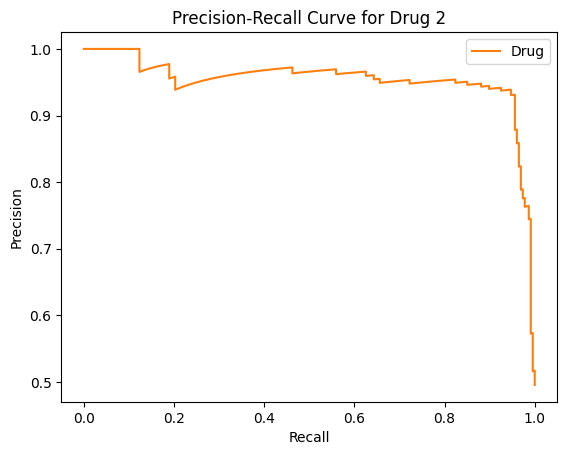

PR-AUC for Drug 2: 0.9535


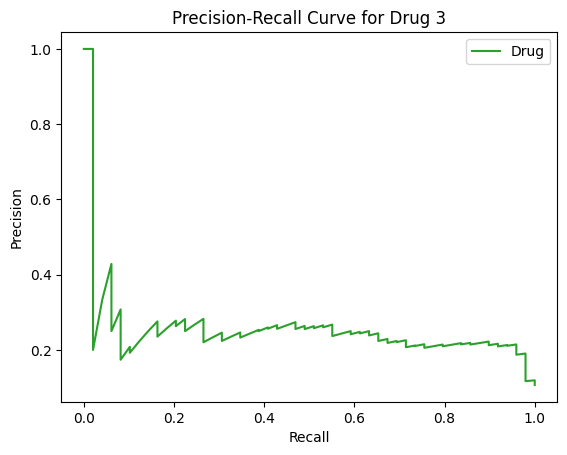

PR-AUC for Drug 3: 0.2534

Epoch 4/20
Training Loss: 0.3402
Validation Loss: 0.2957
Learning Rate: 9.41e-06

Validation Metrics:
----------------------------------------
Precision: 0.8591
Recall: 0.8403
F1 Score: 0.8496
Accuracy: 0.9010
Specificity: 0.9313
Npv: 0.9213

Confusion Matrix Elements:
True Positives: 384
True Negatives: 854
False Positives: 63
False Negatives: 73
----------------------------------------


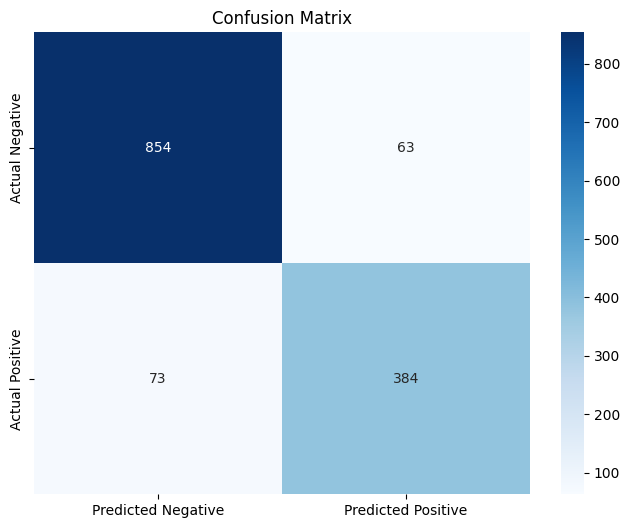

Saved best model!


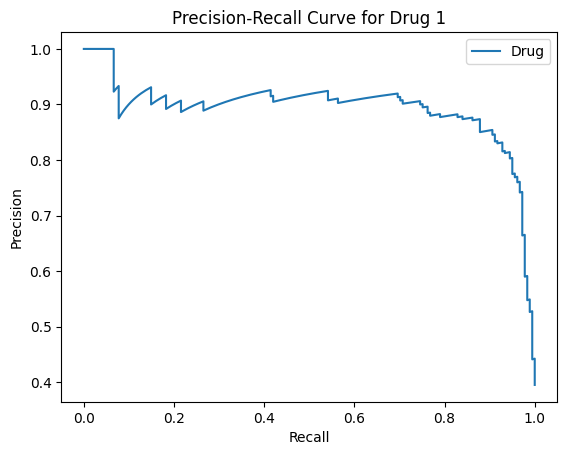

PR-AUC for Drug 1: 0.8932


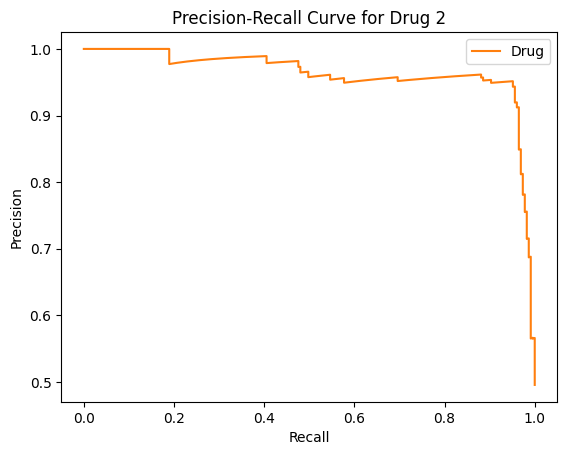

PR-AUC for Drug 2: 0.9634


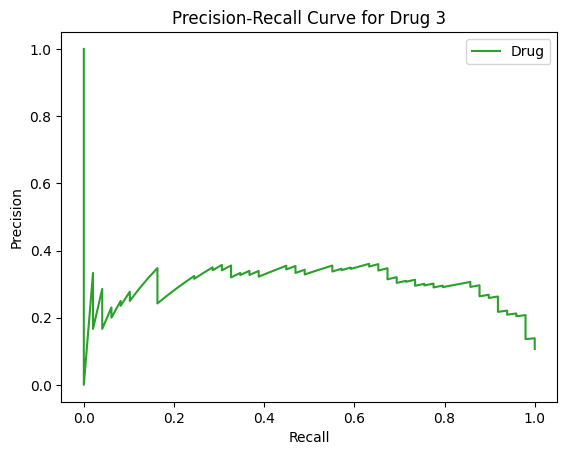

PR-AUC for Drug 3: 0.2982

Epoch 5/20
Training Loss: 0.2933
Validation Loss: 0.2697
Learning Rate: 8.82e-06

Validation Metrics:
----------------------------------------
Precision: 0.8603
Recall: 0.8490
F1 Score: 0.8546
Accuracy: 0.9039
Specificity: 0.9313
Npv: 0.9252

Confusion Matrix Elements:
True Positives: 388
True Negatives: 854
False Positives: 63
False Negatives: 69
----------------------------------------


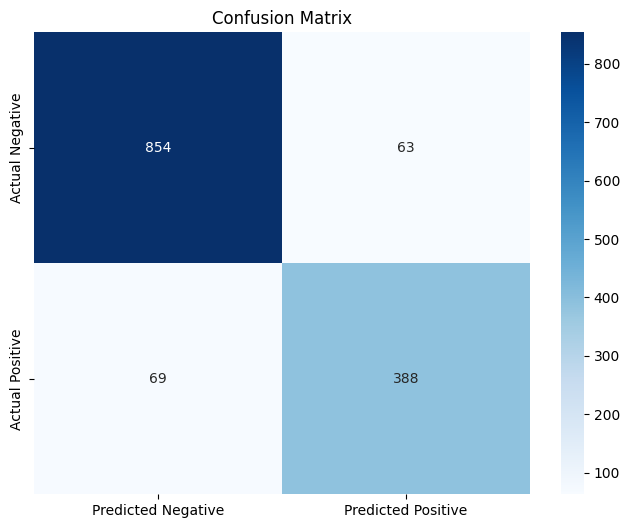

Saved best model!


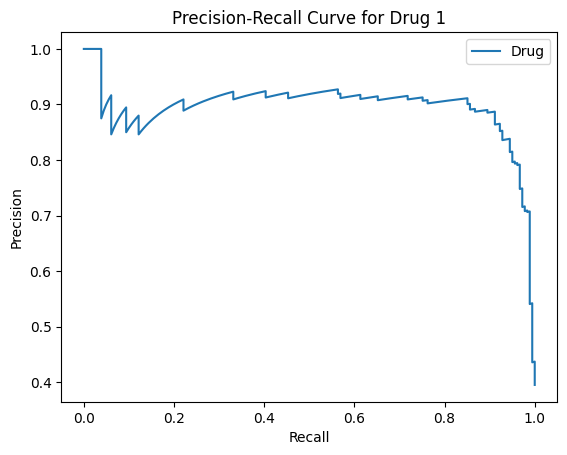

PR-AUC for Drug 1: 0.8954


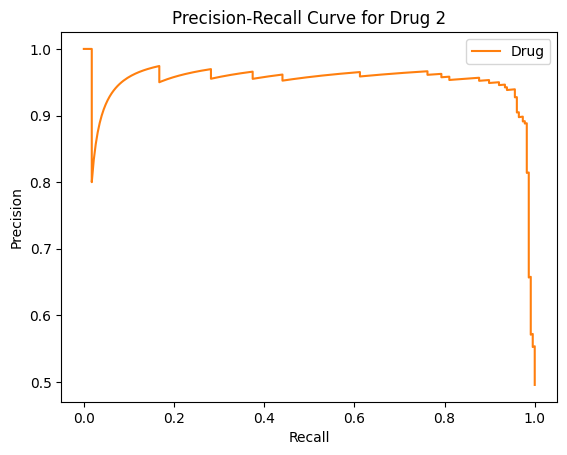

PR-AUC for Drug 2: 0.9498


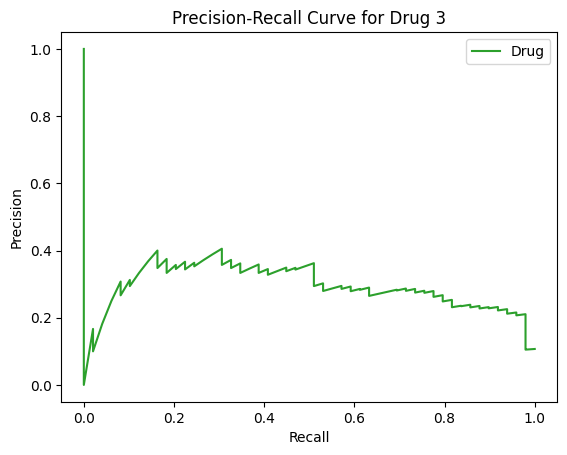

PR-AUC for Drug 3: 0.2897

Epoch 6/20
Training Loss: 0.2721
Validation Loss: 0.3013
Learning Rate: 8.24e-06

Validation Metrics:
----------------------------------------
Precision: 0.8397
Recall: 0.8600
F1 Score: 0.8497
Accuracy: 0.8988
Specificity: 0.9182
Npv: 0.9294

Confusion Matrix Elements:
True Positives: 393
True Negatives: 842
False Positives: 75
False Negatives: 64
----------------------------------------


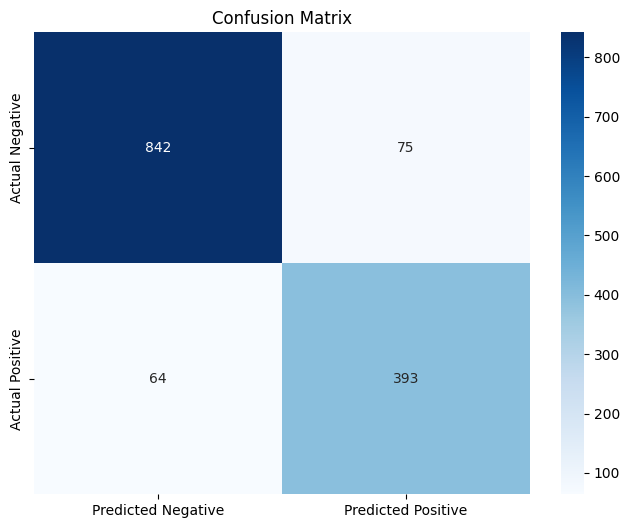

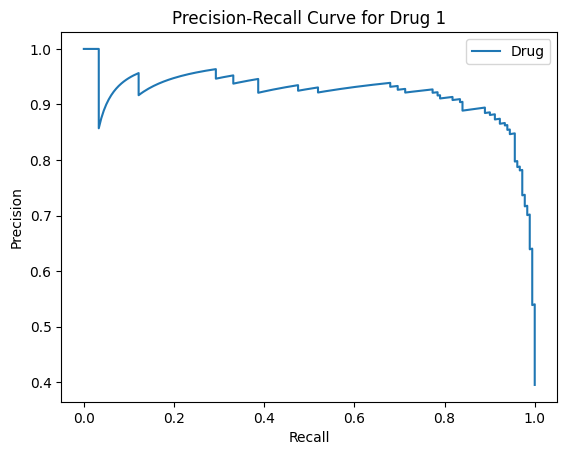

PR-AUC for Drug 1: 0.9190


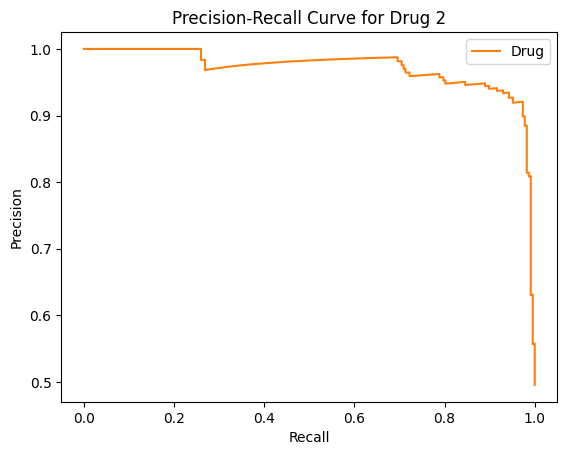

PR-AUC for Drug 2: 0.9713


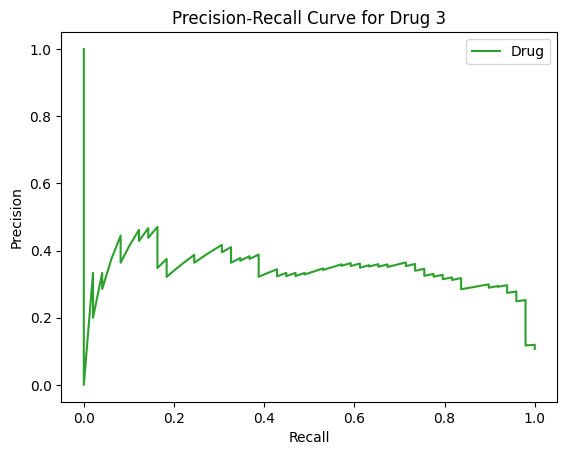

PR-AUC for Drug 3: 0.3398

Epoch 7/20
Training Loss: 0.2493
Validation Loss: 0.2567
Learning Rate: 7.65e-06

Validation Metrics:
----------------------------------------
Precision: 0.8826
Recall: 0.8556
F1 Score: 0.8689
Accuracy: 0.9141
Specificity: 0.9433
Npv: 0.9291

Confusion Matrix Elements:
True Positives: 391
True Negatives: 865
False Positives: 52
False Negatives: 66
----------------------------------------


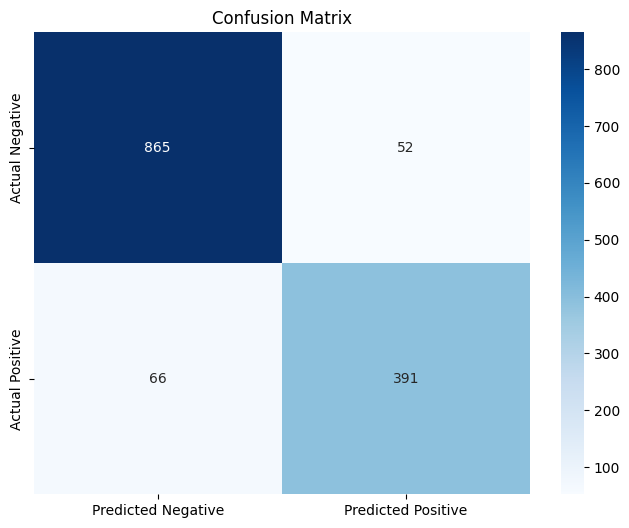

Saved best model!


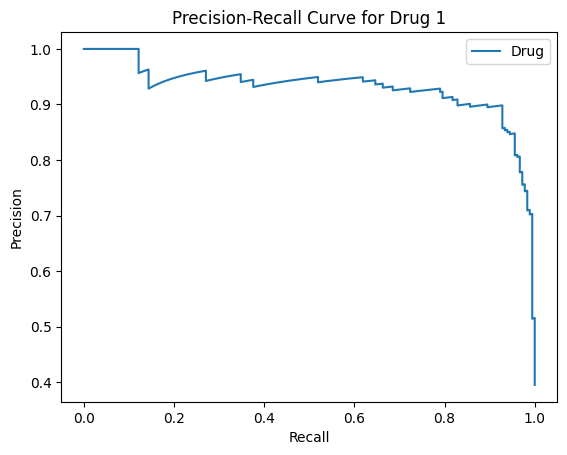

PR-AUC for Drug 1: 0.9315


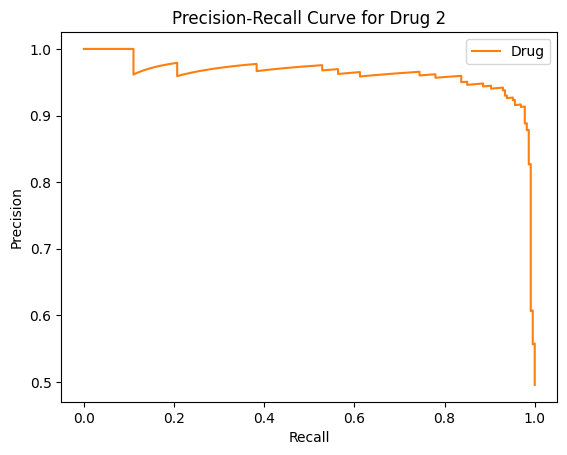

PR-AUC for Drug 2: 0.9620


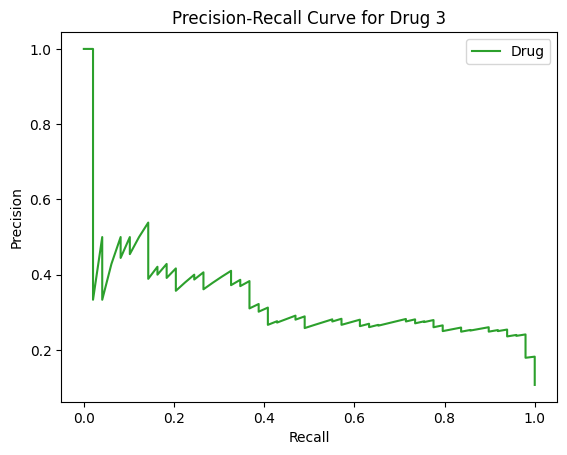

PR-AUC for Drug 3: 0.3322

Epoch 8/20
Training Loss: 0.2408
Validation Loss: 0.3070
Learning Rate: 7.06e-06

Validation Metrics:
----------------------------------------
Precision: 0.8465
Recall: 0.8687
F1 Score: 0.8575
Accuracy: 0.9039
Specificity: 0.9215
Npv: 0.9337

Confusion Matrix Elements:
True Positives: 397
True Negatives: 845
False Positives: 72
False Negatives: 60
----------------------------------------


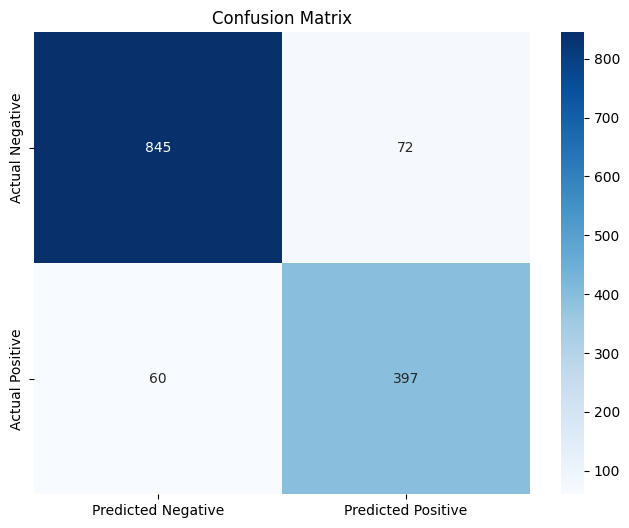

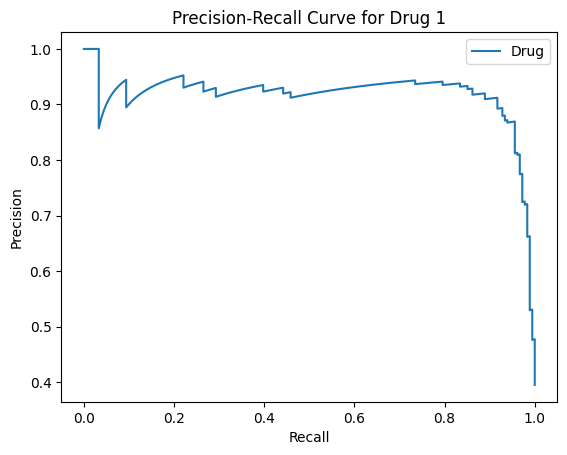

PR-AUC for Drug 1: 0.9182


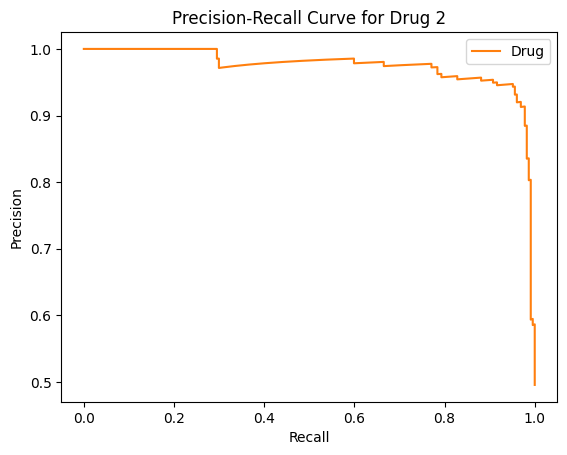

PR-AUC for Drug 2: 0.9743


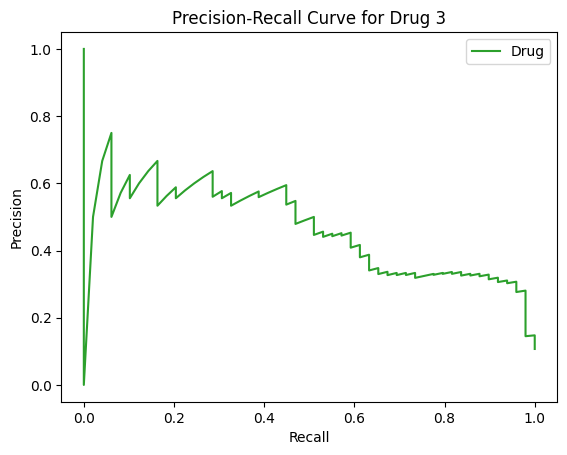

PR-AUC for Drug 3: 0.4557

Epoch 9/20
Training Loss: 0.2278
Validation Loss: 0.2411
Learning Rate: 6.47e-06

Validation Metrics:
----------------------------------------
Precision: 0.9049
Recall: 0.8534
F1 Score: 0.8784
Accuracy: 0.9214
Specificity: 0.9553
Npv: 0.9290

Confusion Matrix Elements:
True Positives: 390
True Negatives: 876
False Positives: 41
False Negatives: 67
----------------------------------------


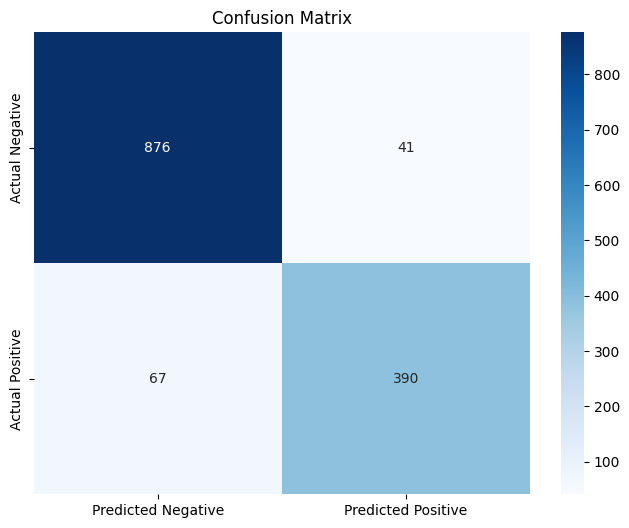

Saved best model!


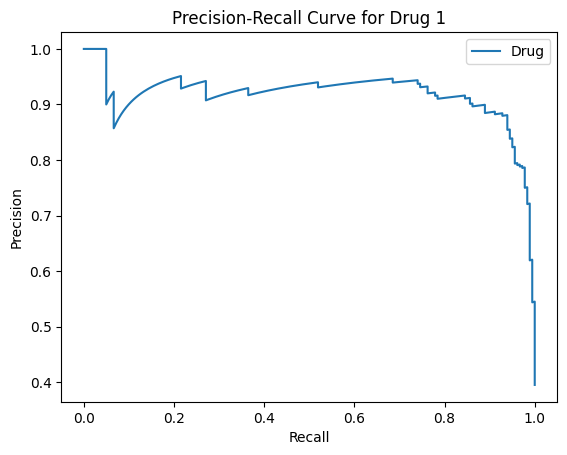

PR-AUC for Drug 1: 0.9179


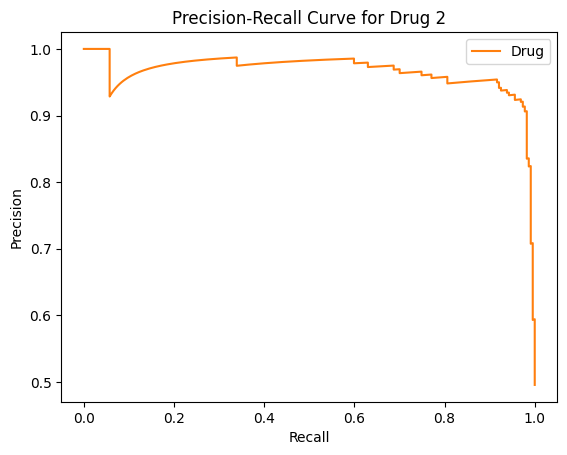

PR-AUC for Drug 2: 0.9663


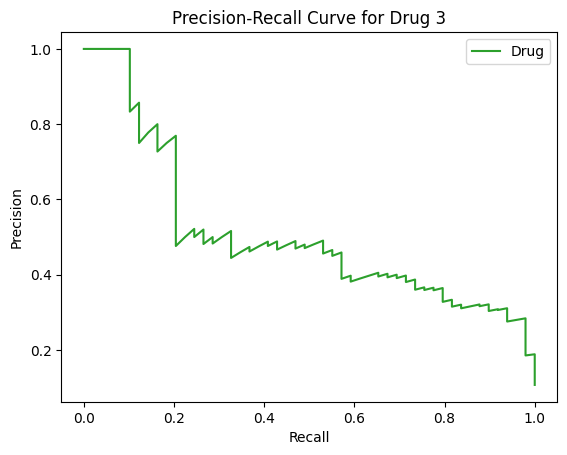

PR-AUC for Drug 3: 0.5050

Epoch 10/20
Training Loss: 0.2187
Validation Loss: 0.2875
Learning Rate: 5.88e-06

Validation Metrics:
----------------------------------------
Precision: 0.8502
Recall: 0.8818
F1 Score: 0.8657
Accuracy: 0.9090
Specificity: 0.9226
Npv: 0.9400

Confusion Matrix Elements:
True Positives: 403
True Negatives: 846
False Positives: 71
False Negatives: 54
----------------------------------------


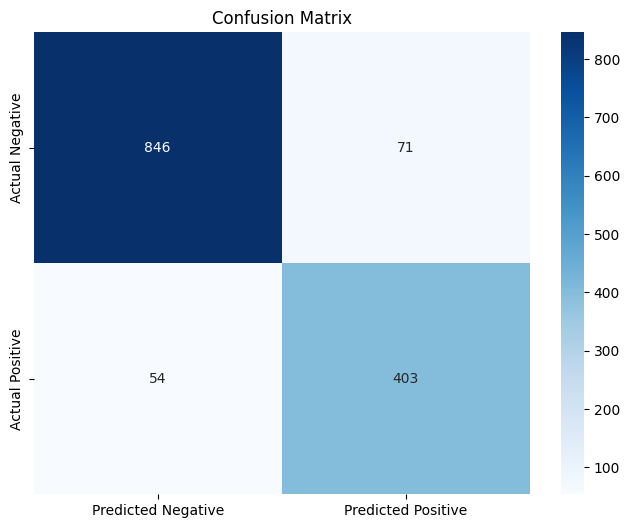

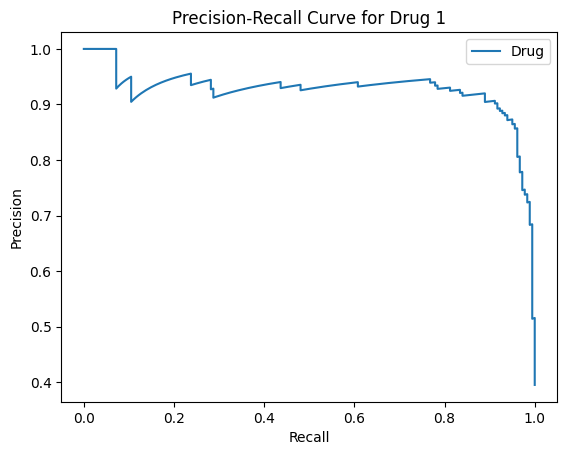

PR-AUC for Drug 1: 0.9263


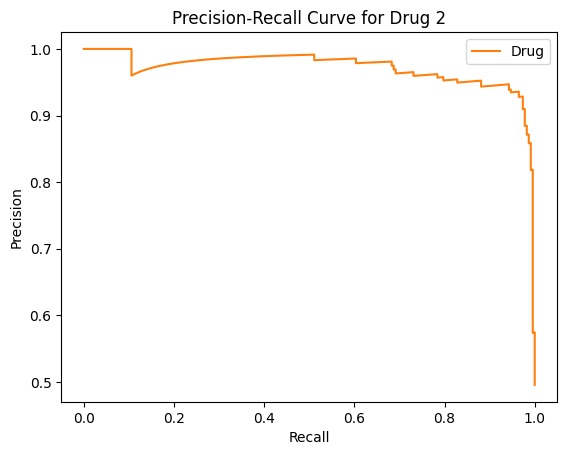

PR-AUC for Drug 2: 0.9716


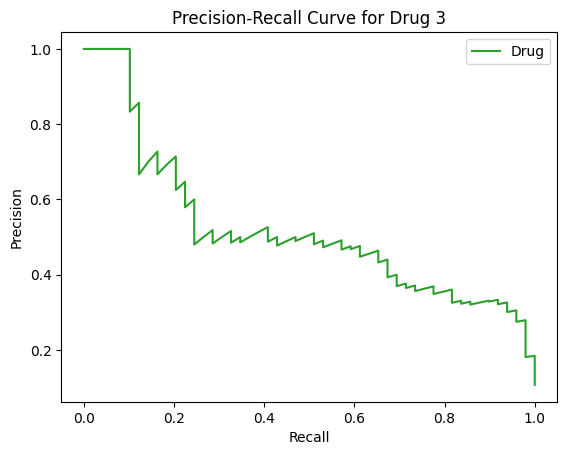

PR-AUC for Drug 3: 0.5177

Epoch 11/20
Training Loss: 0.1997
Validation Loss: 0.2841
Learning Rate: 5.29e-06

Validation Metrics:
----------------------------------------
Precision: 0.8310
Recall: 0.8928
F1 Score: 0.8608
Accuracy: 0.9039
Specificity: 0.9095
Npv: 0.9445

Confusion Matrix Elements:
True Positives: 408
True Negatives: 834
False Positives: 83
False Negatives: 49
----------------------------------------


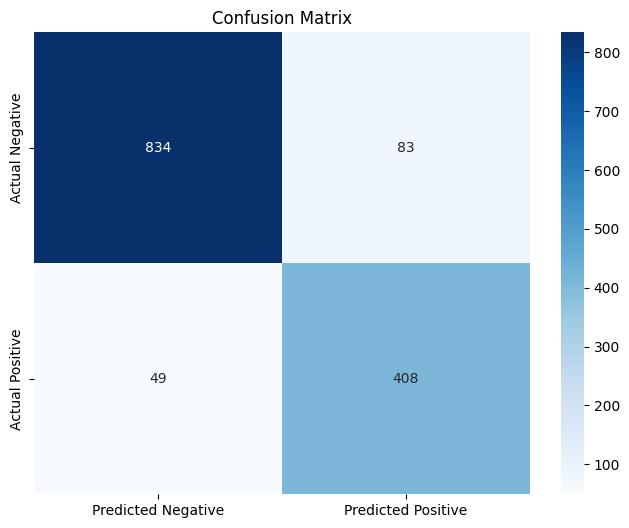

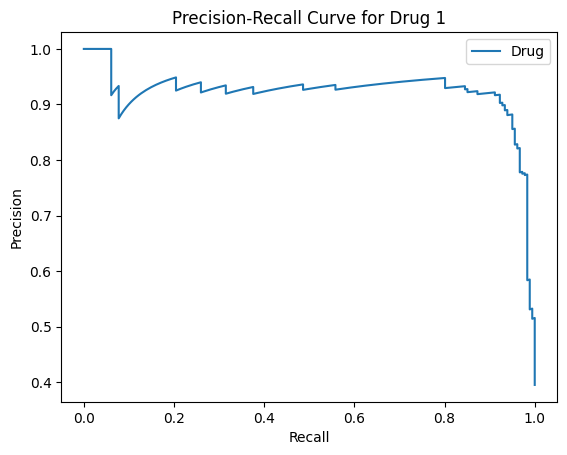

PR-AUC for Drug 1: 0.9227


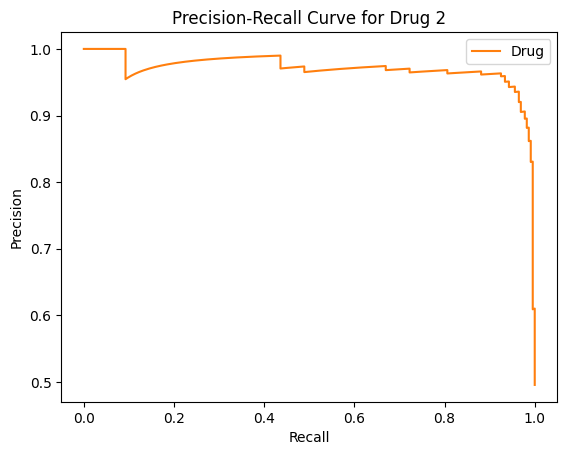

PR-AUC for Drug 2: 0.9704


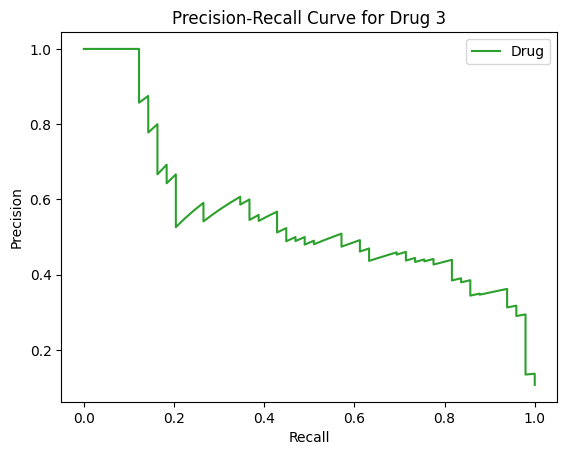

PR-AUC for Drug 3: 0.5520

Epoch 12/20
Training Loss: 0.1907
Validation Loss: 0.2404
Learning Rate: 4.71e-06

Validation Metrics:
----------------------------------------
Precision: 0.8604
Recall: 0.9037
F1 Score: 0.8815
Accuracy: 0.9192
Specificity: 0.9269
Npv: 0.9508

Confusion Matrix Elements:
True Positives: 413
True Negatives: 850
False Positives: 67
False Negatives: 44
----------------------------------------


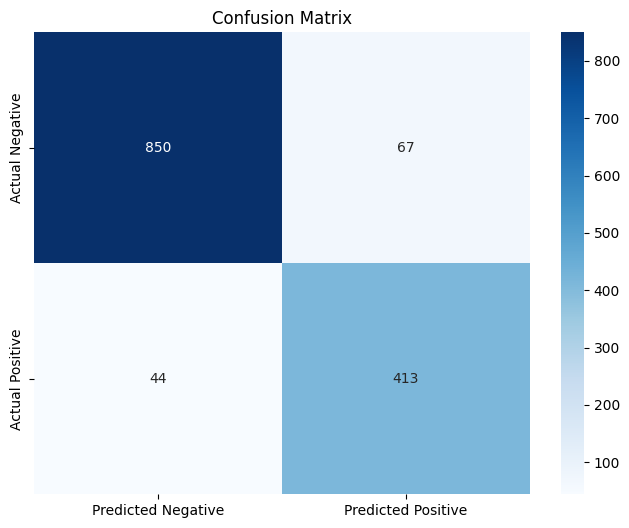

Saved best model!


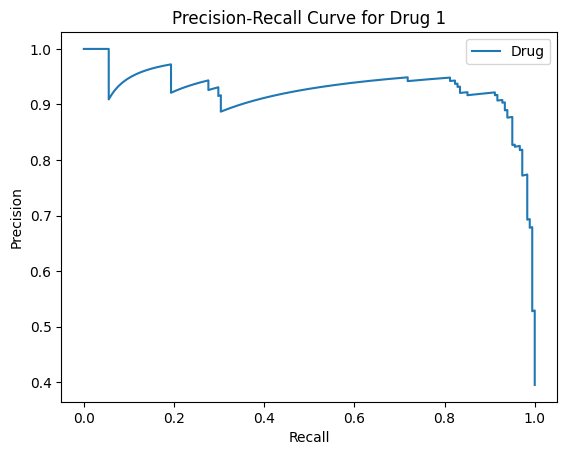

PR-AUC for Drug 1: 0.9261


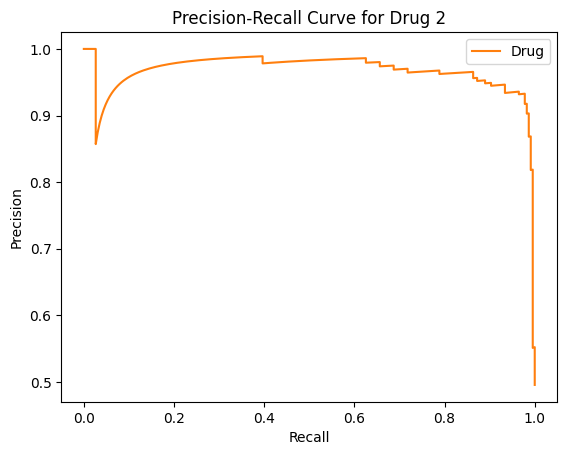

PR-AUC for Drug 2: 0.9667


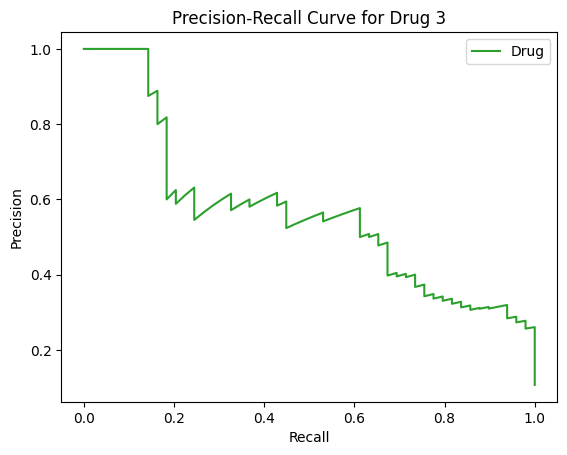

PR-AUC for Drug 3: 0.5636

Epoch 13/20
Training Loss: 0.1840
Validation Loss: 0.2432
Learning Rate: 4.12e-06

Validation Metrics:
----------------------------------------
Precision: 0.8491
Recall: 0.9234
F1 Score: 0.8847
Accuracy: 0.9199
Specificity: 0.9182
Npv: 0.9601

Confusion Matrix Elements:
True Positives: 422
True Negatives: 842
False Positives: 75
False Negatives: 35
----------------------------------------


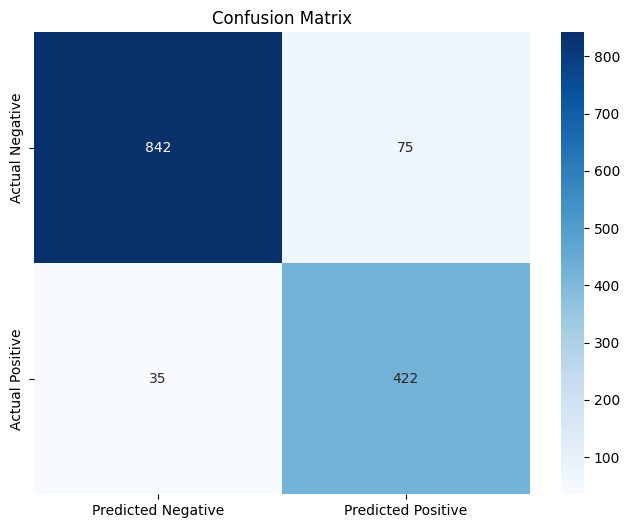

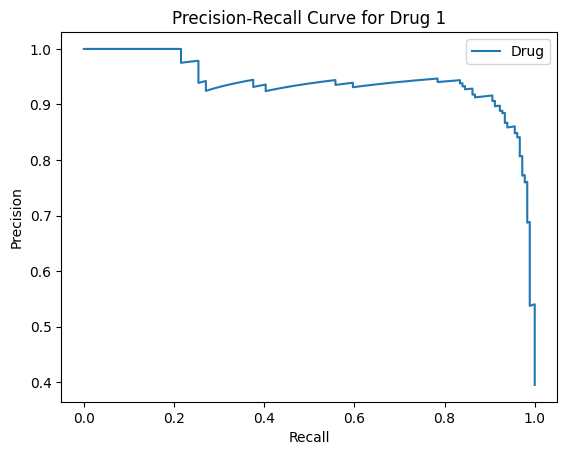

PR-AUC for Drug 1: 0.9390


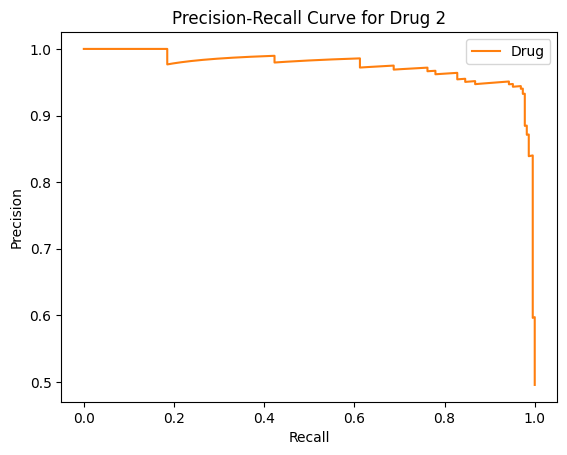

PR-AUC for Drug 2: 0.9747


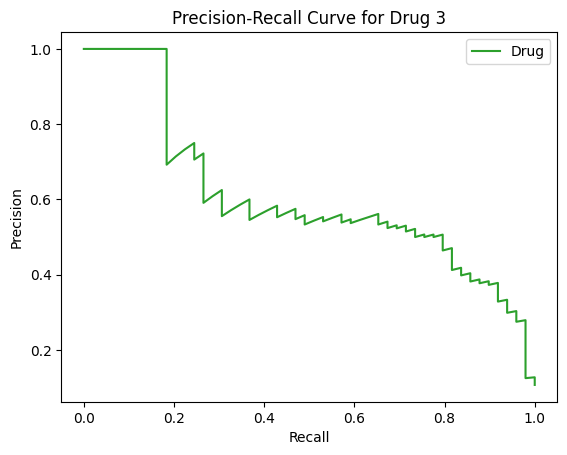

PR-AUC for Drug 3: 0.6055

Epoch 14/20
Training Loss: 0.1734
Validation Loss: 0.2373
Learning Rate: 3.53e-06

Validation Metrics:
----------------------------------------
Precision: 0.8557
Recall: 0.9212
F1 Score: 0.8872
Accuracy: 0.9221
Specificity: 0.9226
Npv: 0.9592

Confusion Matrix Elements:
True Positives: 421
True Negatives: 846
False Positives: 71
False Negatives: 36
----------------------------------------


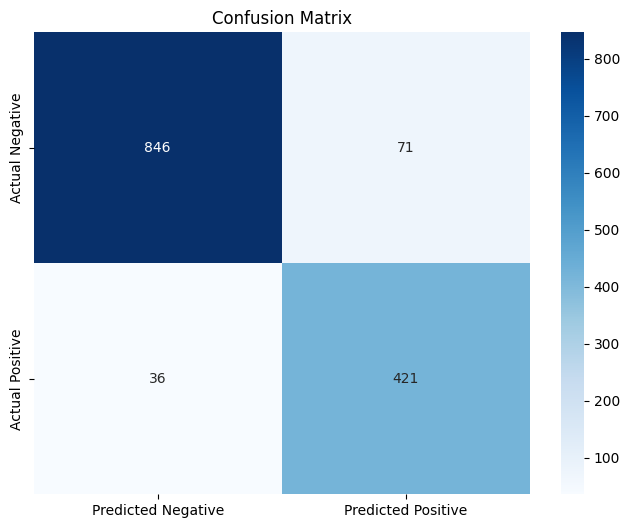

Saved best model!


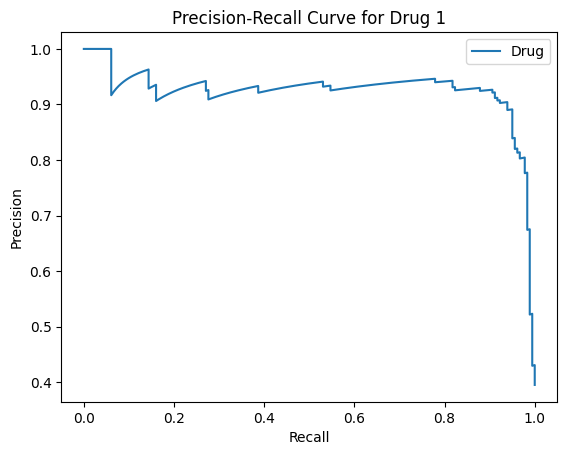

PR-AUC for Drug 1: 0.9250


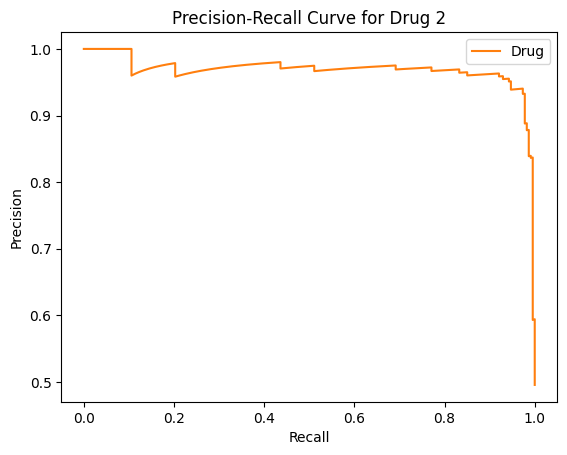

PR-AUC for Drug 2: 0.9685


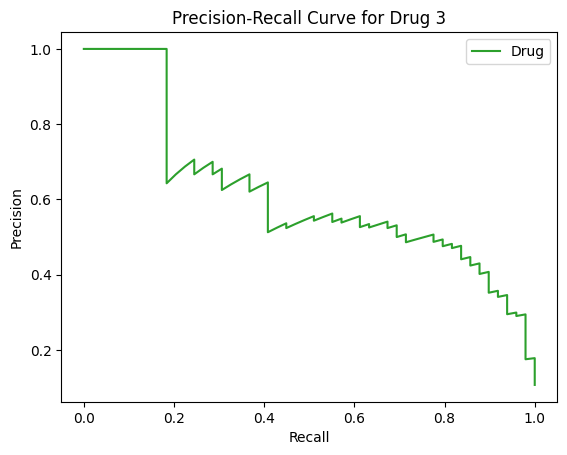

PR-AUC for Drug 3: 0.6121

Epoch 15/20
Training Loss: 0.1695
Validation Loss: 0.2476
Learning Rate: 2.94e-06

Validation Metrics:
----------------------------------------
Precision: 0.8373
Recall: 0.9344
F1 Score: 0.8831
Accuracy: 0.9178
Specificity: 0.9095
Npv: 0.9653

Confusion Matrix Elements:
True Positives: 427
True Negatives: 834
False Positives: 83
False Negatives: 30
----------------------------------------


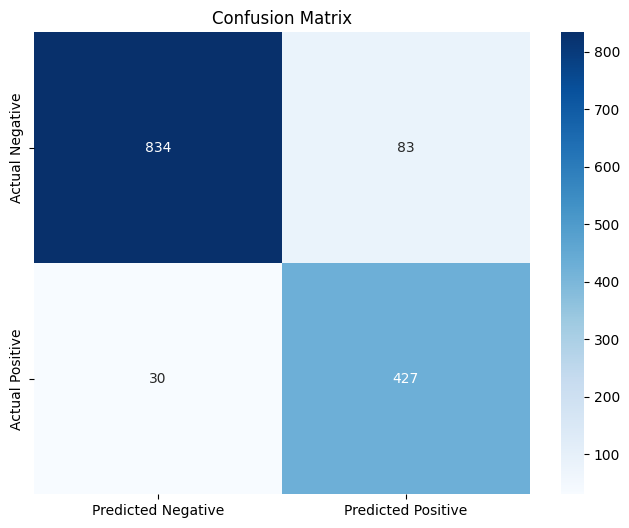

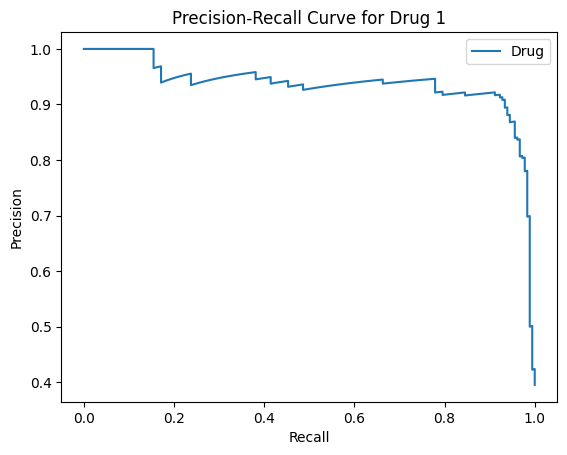

PR-AUC for Drug 1: 0.9364


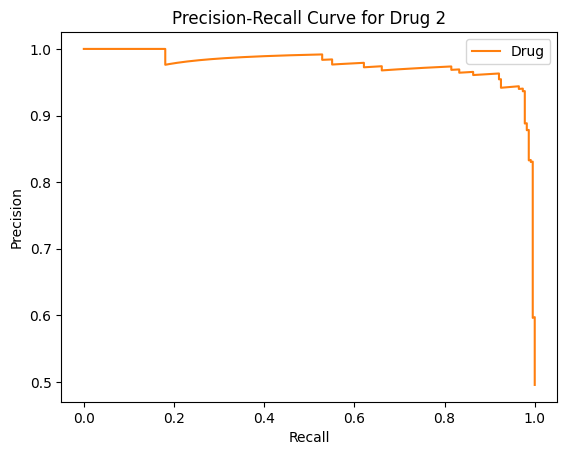

PR-AUC for Drug 2: 0.9765


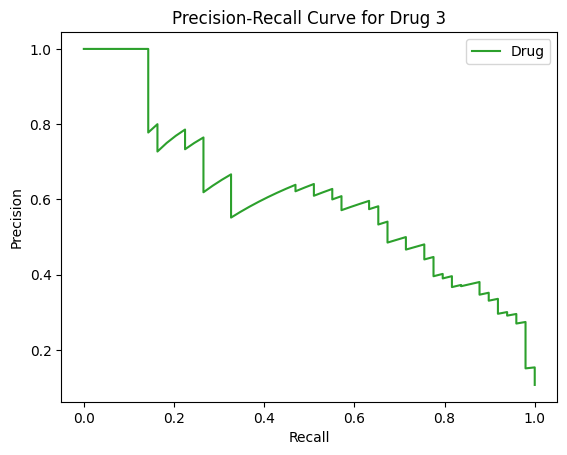

PR-AUC for Drug 3: 0.6050

Epoch 16/20
Training Loss: 0.1577
Validation Loss: 0.2297
Learning Rate: 2.35e-06

Validation Metrics:
----------------------------------------
Precision: 0.8683
Recall: 0.9234
F1 Score: 0.8950
Accuracy: 0.9279
Specificity: 0.9302
Npv: 0.9606

Confusion Matrix Elements:
True Positives: 422
True Negatives: 853
False Positives: 64
False Negatives: 35
----------------------------------------


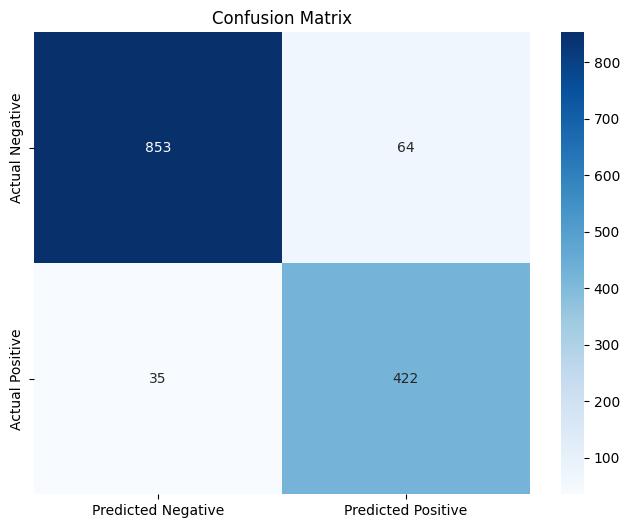

Saved best model!


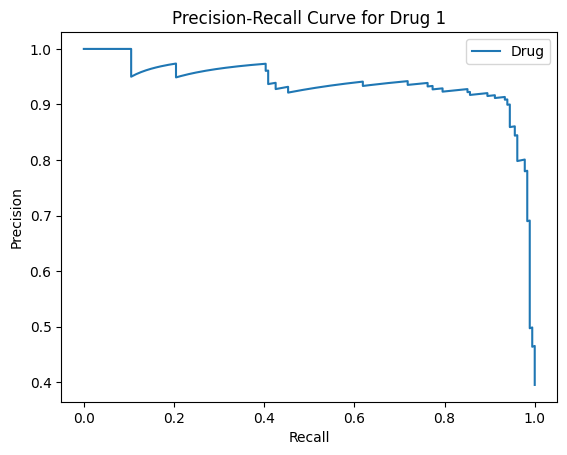

PR-AUC for Drug 1: 0.9371


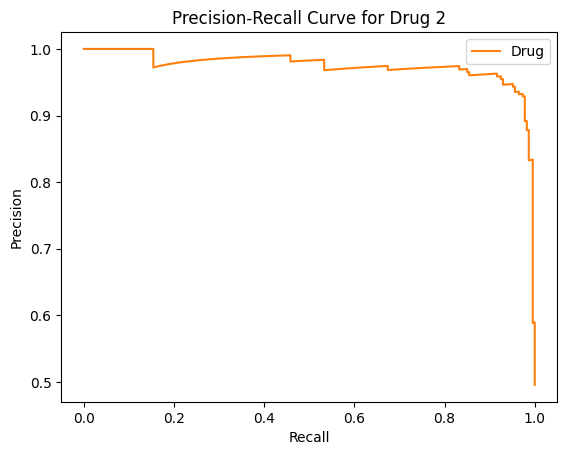

PR-AUC for Drug 2: 0.9746


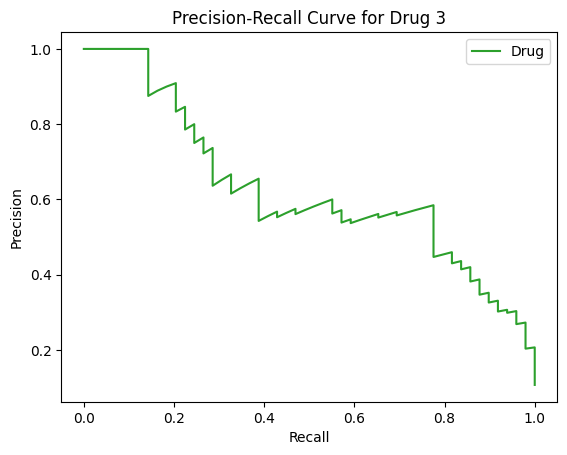

PR-AUC for Drug 3: 0.6252

Epoch 17/20
Training Loss: 0.1516
Validation Loss: 0.2476
Learning Rate: 1.76e-06

Validation Metrics:
----------------------------------------
Precision: 0.8586
Recall: 0.9300
F1 Score: 0.8929
Accuracy: 0.9258
Specificity: 0.9237
Npv: 0.9636

Confusion Matrix Elements:
True Positives: 425
True Negatives: 847
False Positives: 70
False Negatives: 32
----------------------------------------


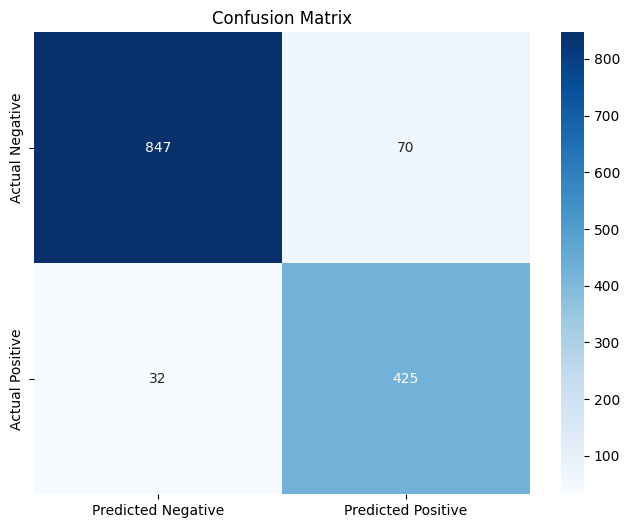

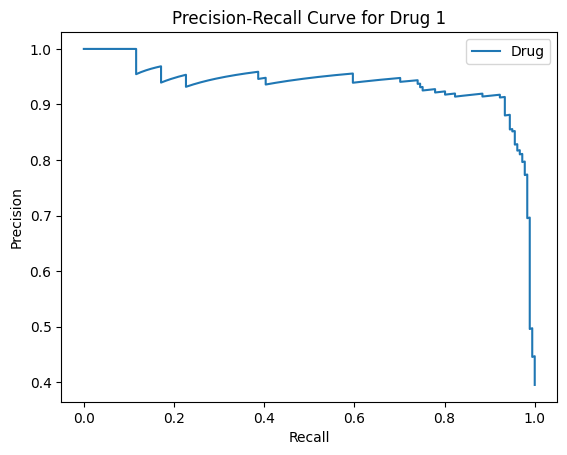

PR-AUC for Drug 1: 0.9360


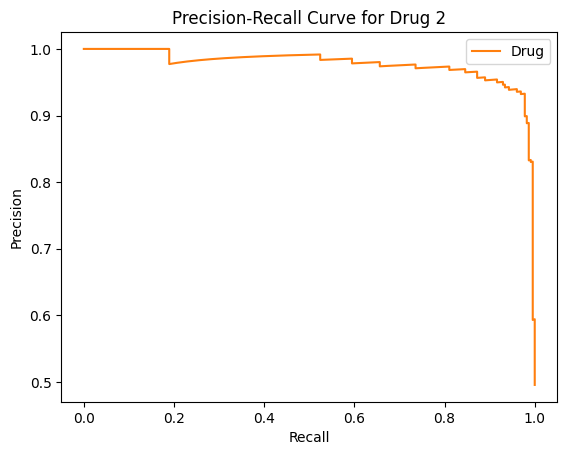

PR-AUC for Drug 2: 0.9773


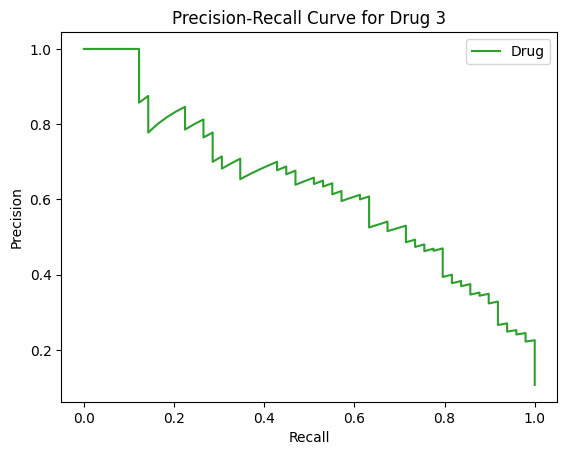

PR-AUC for Drug 3: 0.6295

Epoch 18/20
Training Loss: 0.1510
Validation Loss: 0.2374
Learning Rate: 1.18e-06

Validation Metrics:
----------------------------------------
Precision: 0.8633
Recall: 0.9256
F1 Score: 0.8933
Accuracy: 0.9265
Specificity: 0.9269
Npv: 0.9615

Confusion Matrix Elements:
True Positives: 423
True Negatives: 850
False Positives: 67
False Negatives: 34
----------------------------------------


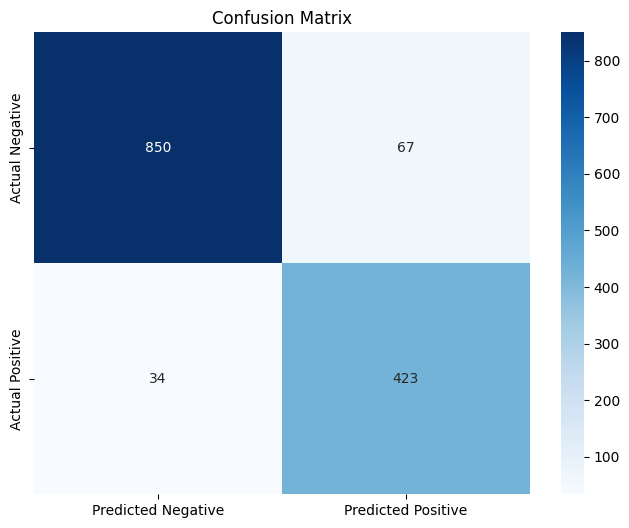

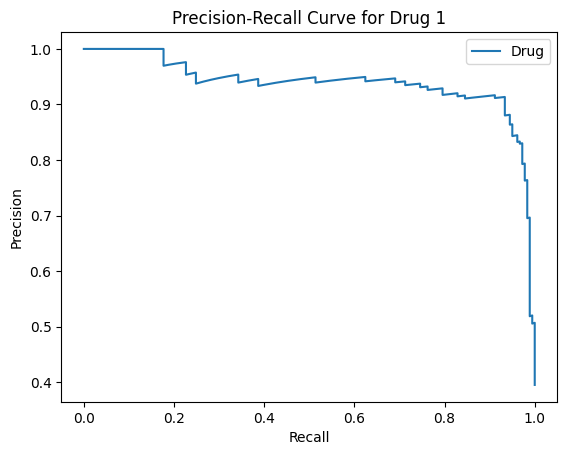

PR-AUC for Drug 1: 0.9391


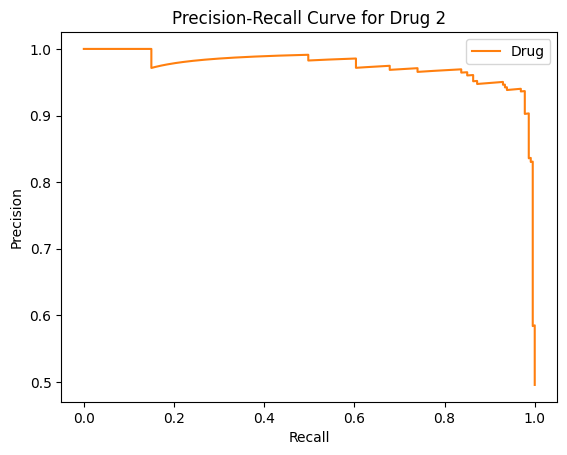

PR-AUC for Drug 2: 0.9747


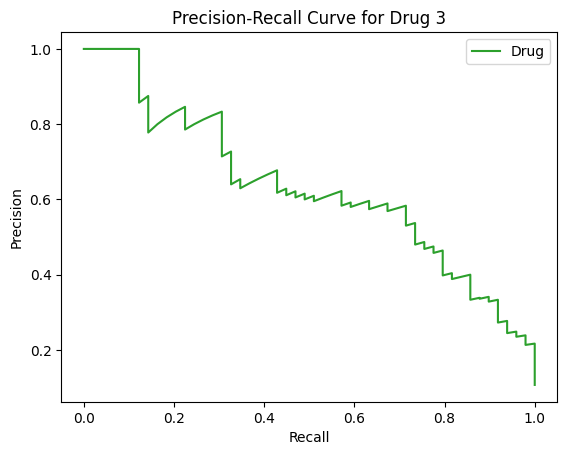

PR-AUC for Drug 3: 0.6294

Epoch 19/20
Training Loss: 0.1415
Validation Loss: 0.2436
Learning Rate: 5.88e-07

Validation Metrics:
----------------------------------------
Precision: 0.8540
Recall: 0.9344
F1 Score: 0.8924
Accuracy: 0.9250
Specificity: 0.9204
Npv: 0.9657

Confusion Matrix Elements:
True Positives: 427
True Negatives: 844
False Positives: 73
False Negatives: 30
----------------------------------------


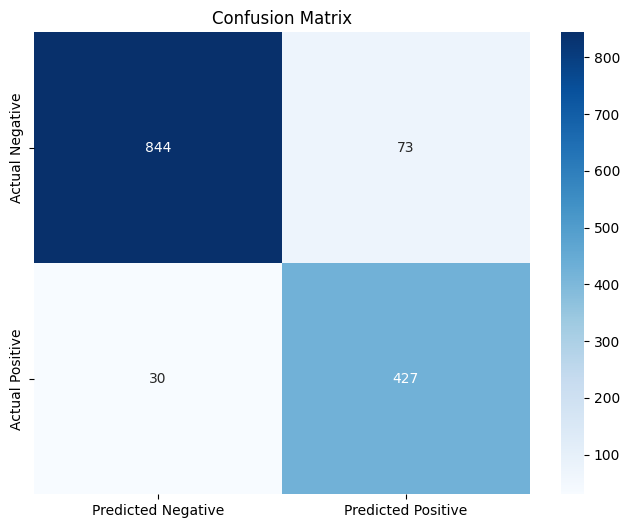

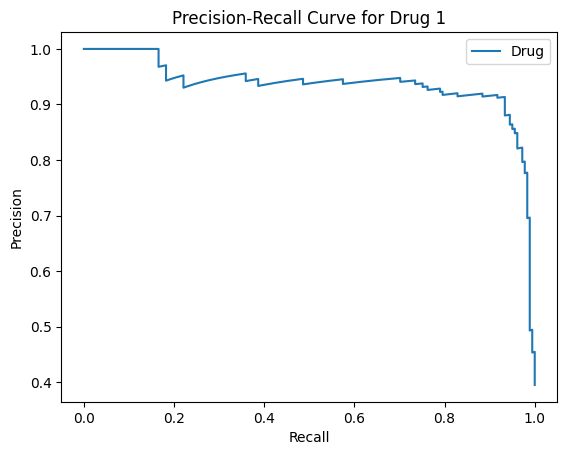

PR-AUC for Drug 1: 0.9367


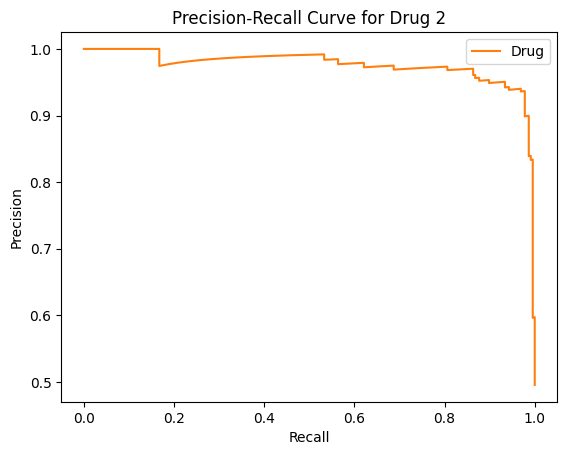

PR-AUC for Drug 2: 0.9762


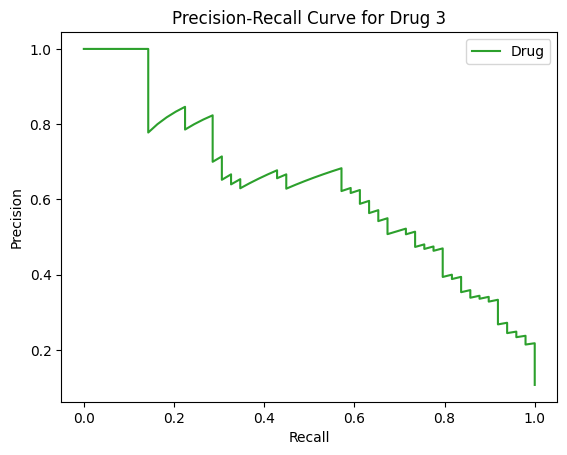

PR-AUC for Drug 3: 0.6316

Epoch 20/20
Training Loss: 0.1389
Validation Loss: 0.2401
Learning Rate: 0.00e+00

Validation Metrics:
----------------------------------------
Precision: 0.8638
Recall: 0.9300
F1 Score: 0.8957
Accuracy: 0.9279
Specificity: 0.9269
Npv: 0.9637

Confusion Matrix Elements:
True Positives: 425
True Negatives: 850
False Positives: 67
False Negatives: 32
----------------------------------------


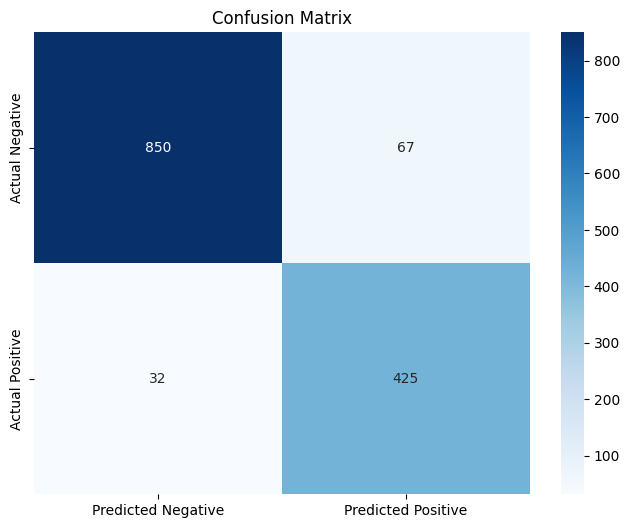

In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Enhanced training configuration
    config = {
        'batch_size': 8,             # Maintained for better gradient estimates
        'learning_rate': 1e-5,        # Slightly reduced for stability
        'num_epochs': 20,             # Increased epochs for deeper convergence
        'warmup_ratio': 0.15,         # Extended warmup to 15%

    # Advanced Class Imbalance Handling
        'class_weights': {
              0: 1.0,                  # Majority class (non-resistance)
              1: 14.0                   # Minority class (resistance) - weighted higher
    },

    # Enhanced Loss Function
        'loss_type': 'focal_loss',
        'focal_gamma': 3.5,           # Refined focal loss parameter
        'focal_alpha': 0.75,          # Maintained alpha for class balance

    # Comprehensive Regularization
        'weight_decay': 0.015,        # Slightly increased
        'dropout_rate': 0.35,         # Increased dropout
        'label_smoothing': 0.15,      # Enhanced label smoothing

    # Advanced Training Optimizations
        'gradient_accumulation_steps': 4,
        'max_grad_norm': 1.2,         # Slight increase in gradient clipping
        'scheduler': 'triangular_with_warmup',  # More dynamic learning rate

    # Sophisticated Early Stopping
        'patience': 7,                # Extended patience
        'monitor_metric': 'recall',   # Maintained focus on recall

    # Enhanced Data Augmentation
        'augmentation': {
            'enable': True,
            'synonym_replacement_prob': 0.4,    # Increased probability
            'backtranslation_prob': 0.3,        # Enhanced probability
            'random_swap_prob': 0.2,            # Increased swap probability
            'noise_injection_prob': 0.2,        # Added noise injection
            'contextual_augment_prob': 0.1      # New contextual augmentation
        },

    # Additional Regularization Techniques
        'l1_regularization': 0.001,   # Added L1 regularization

    # Ensemble Preparation
        'ensemble_strategy': {
            'enable': True,
            'models_to_ensemble': 3,
            'aggregation_method': 'weighted_vote'
        }
    }

    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
    model = AutoModelForSequenceClassification.from_pretrained(
        "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
        num_labels=3,
        problem_type="multi_label_classification"
    ).to(device)

    # Add dropout for regularization
    model.dropout = torch.nn.Dropout(0.3)

    df = upload_and_process_file()
    sequences, labels = process_resistance_data(df)

    # Stratified split to handle imbalanced data
    X_train, X_val, y_train, y_val = train_test_split(
        sequences, labels,
        test_size=0.2,
        random_state=42
    )

    train_dataset = HIVDrugResistanceDataset(X_train, y_train, tokenizer)
    val_dataset = HIVDrugResistanceDataset(X_val, y_val, tokenizer)

    model, training_stats = train_model(train_dataset, val_dataset, model, device, config)
    return model, training_stats

if __name__ == "__main__":
    main()